In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import ClusterCentroids
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [4]:
treino = pd.read_csv("train.csv")
teste = pd.read_csv("test.csv")

treino = treino.drop(columns=['nome', 'sequencial_candidato'])
teste = teste.drop(columns=['nome', 'sequencial_candidato'])

In [5]:
numeric_feats = treino.dtypes[treino.dtypes != "object"].index

numeric_feats = numeric_feats.drop('ano')
numeric_feats = numeric_feats.drop('situacao')

treino[numeric_feats] = np.log1p(treino[numeric_feats])

teste[numeric_feats] = np.log1p(teste[numeric_feats])

In [6]:
allData = pd.concat((teste,treino), sort=False)

teste = allData.loc[:,:'ocupacao']
teste = pd.get_dummies(teste)

treino_X = teste.loc[teste['ano'] != 2014]
teste = teste.loc[teste['ano'] == 2014]

treino_Y = allData.loc[allData['ano'] != 2014]
treino_Y = treino_Y.loc[:,'situacao']

In [7]:
treino_X = treino.loc[:,:'ocupacao']
treino_Y = treino.loc[:,'situacao']

In [8]:
treino_X = pd.get_dummies(treino_X)
teste = pd.get_dummies(teste)

## 1) Há desbalanceamento das classes? Em que proporção? 

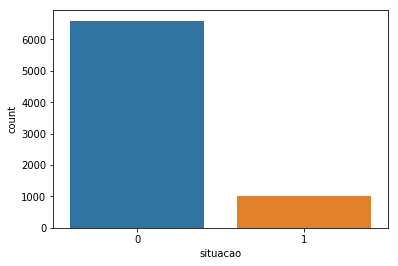

In [9]:
sns.countplot(treino_Y)

É clara a diferença entre a quantidade de instâncias da classe nao_eleito e eleito. Isso pode levar o modelo a aprender de forma errada, pois pode deixar o modelo enviesado, classificando as instâncias como sendo da classe majoritária.

Para balancear as classes usarei a técnica de under-sampling, cluser centroids.

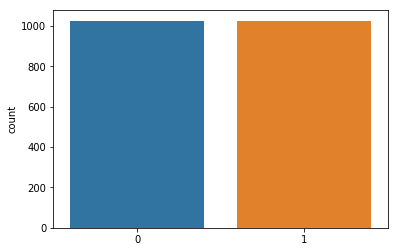

In [10]:
cc = ClusterCentroids()
x_cc, y_cc = cc.fit_sample(treino_X, treino_Y)
y_cc = y_cc[:,np.newaxis]

sns.countplot(y_cc[:,0])

Com a mesma quantidade de instâncias entre as duas classes, a chance de o modelo sofrer de underfiting é bem menor.

In [11]:
data = np.concatenate((x_cc, y_cc), axis=1)
data = np.random.permutation(data)
x_cc = data[:,0:-1]
y_cc = data[:,-1]
y_cc = y_cc.astype('int')

Para melhorar a validação dos modelos, utilizo uma função para fazer uma permutação aleatória nos dados, pois esses ficam agrupados na saída da função de cluster centroids.

In [12]:
treino_X = np.array(treino_X)
treino_Y = np.array(treino_Y)

Alterei o tipo do data frame para array, para a função de report funcionar apropriadamente.

In [42]:
def metric_report(model, predictors, outcome, nfolds):
    
    kf = KFold(n_splits=nfolds)
    
    precision = [[],[]]
    recall = [[],[]]
    f1_score = [[],[]]
    
    for train, validation in kf.split(predictors):
        train_predictors = (predictors[train,:])
        train_target =  outcome[train]
        model.fit(train_predictors, train_target)
        
        predTrain = model.predict(predictors[train,:])
        report = metrics.classification_report(outcome[train], predTrain, output_dict=True)
        precision[0].append(report['1']['precision'])
        recall[0].append(report['1']['recall'])
        f1_score[0].append(report['1']['f1-score'])
        
        predVal = model.predict(predictors[validation,:])
        report = metrics.classification_report(outcome[validation], predVal, output_dict=True)
        precision[1].append(report['1']['precision'])
        recall[1].append(report['1']['recall'])
        f1_score[1].append(report['1']['f1-score'])
        
    retorno = [[],[]]
    retorno[0] = [np.mean(precision[0]),np.mean(recall[0]),np.mean(f1_score[0])]
    retorno[1] = [np.mean(precision[1]),np.mean(recall[1]),np.mean(f1_score[1])]
    return retorno

In [14]:
def validation_report(model, validationX, validationY):
    
    predVal = model.predict(validationX)
    report = metrics.classification_report(validationY, predVal, output_dict=True)
    
    return [report["1"]["precision"],report["1"]["recall"],report["1"]["f1-score"]]

In [15]:
def cv_report(model, predictors, outcome, nfolds):
    
    kf = KFold(n_splits=nfolds)
    f1_score = []
    
    for train, validation in kf.split(predictors):
        train_predictors = (predictors[train,:])
        train_target =  outcome[train]
        model.fit(train_predictors, train_target)
        
        predVal = model.predict(predictors[validation,:])
        report = metrics.classification_report(outcome[validation], predVal, output_dict=True)
        f1_score.append(report['1']['f1-score'])

    return np.mean(f1_score)

Função que retorna o precision, recall e F1, no treino e na validação. Os calculos são referentes apenas à variável eleito.

In [16]:
def real_f1(model):
    return metrics.classification_report(treino_Y, model.predict(treino_X), output_dict=True)['1']['f1-score']

Função que testa um modelo com todos os dados de 2006 e 2010, e retorna o F1 de um modelo para todos os dados.

In [17]:
def report_full(model,trainX, trainY, n):
    model.fit(trainX, trainY)
    return real_f1(model)

Treina o modelo com alguns dados e chama a função real_f1 para testar o modelo com todos os dados.

## 2) Treine: um modelo de regressão logística, KNN, uma árvore de decisão e um modelo de adaboost.

Os modelos a seguir serão treinados com e sem os dados balanceados, para comparar o desempenho de cada um.

## Regressão Logística

### Dados não balanceados

In [18]:
lambdas = np.arange(0.01,3,0.01).tolist()

In [32]:
cv_logRegUnbalanced = [cv_report(LogisticRegression(solver="lbfgs", max_iter=10000, C=lbd, random_state=1), treino_X, treino_Y, 5)
            for lbd in lambdas]

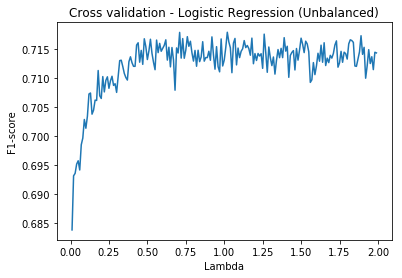

O melhor alpha é 1.02, com F1 = 0.7179456293598359


In [34]:
cv_logRegUnbalanced = pd.Series(cv_logRegUnbalanced, index = lambdas)

cv_logRegUnbalanced.plot(title = "Cross validation - Logistic Regression (Unbalanced)")
plt.xlabel("Lambda")
plt.ylabel("F1-score")
plt.show()

print("O melhor alpha é {0}, com F1 = {1}".format(cv_logRegUnbalanced.idxmax(), cv_logRegUnbalanced.max()))

### Dados balanceados

In [19]:
cv_logRegBalanced = [cv_report(LogisticRegression(solver="lbfgs", max_iter=10000, C=lbd, random_state=1), x_cc, y_cc, 5)
            for lbd in lambdas]
cv_logRegBalanced = pd.Series(cv_logRegBalanced, index = lambdas)

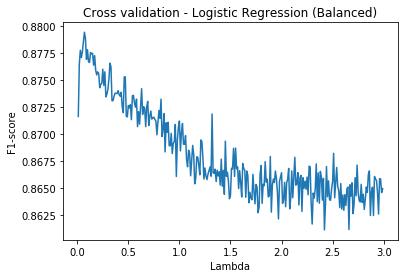

O melhor alpha é 0.06999999999999999, com F1 = 0.8794663274504089


In [20]:
cv_logRegBalanced.plot(title = "Cross validation - Logistic Regression (Balanced)")
plt.xlabel("Lambda")
plt.ylabel("F1-score")
plt.show()

print("O melhor alpha é {0}, com F1 = {1}".format(cv_logRegBalanced.idxmax(), cv_logRegBalanced.max()))

In [21]:
lgModel = LogisticRegression(solver="lbfgs", max_iter=10000, C=cv_logRegBalanced.idxmax(), random_state=1)
lgModel.fit(x_cc,y_cc)

print("O F1 do modelo para todos os dados é {0}".format(real_f1(lgModel)))

O F1 do modelo para todos os dados é 0.7141251405020607


## KNN

### Dados não balanceados

In [22]:
k_list = np.arange(1,100,1).tolist()

In [23]:
cv_knnUnbalanced = [cv_report(KNeighborsClassifier(n_neighbors = n), treino_X, treino_Y, 5).mean()
            for n in k_list]

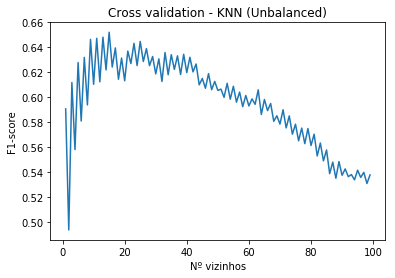

O melhor lambda é 15, com F1-score = 0.6520627049440006


In [24]:
cv_knnUnbalanced = pd.Series(cv_knnUnbalanced, index = k_list)
cv_knnUnbalanced.plot(title = "Cross validation - KNN (Unbalanced)")
plt.xlabel("Nº vizinhos")
plt.ylabel("F1-score")
plt.show()

print("O melhor lambda é {0}, com F1-score = {1}".format(cv_knnUnbalanced.idxmax(), cv_knnUnbalanced.max()))

### Dados balanceados

In [26]:
cv_knnBalanced = [cv_report(KNeighborsClassifier(n_neighbors = n), x_cc, y_cc, 5)
            for n in k_list]

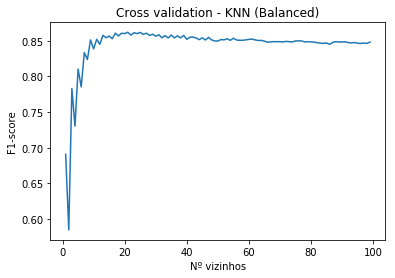

O melhor lambda é 21, com F1-score = 0.8619195883319317


In [27]:
cv_knnBalanced = pd.Series(cv_knnBalanced, index = k_list)
cv_knnBalanced.plot(title = "Cross validation - KNN (Balanced)")
plt.xlabel("Nº vizinhos")
plt.ylabel("F1-score")
plt.show()

print("O melhor lambda é {0}, com F1-score = {1}".format(cv_knnBalanced.idxmax(), cv_knnBalanced.max()))

In [28]:
knnModel = KNeighborsClassifier(n_neighbors=cv_knnBalanced.idxmax())
knnModel.fit(x_cc,y_cc)

print("O F1 do modelo para todos os dados é {0}".format(real_f1(knnModel)))

O F1 do modelo para todos os dados é 0.6904496469713862


## Decision tree

### Dados não balanceados

In [29]:
depth_list = np.arange(1,100,1).tolist()

In [30]:
cv_treeUnbalanced = [cv_report(DecisionTreeClassifier(max_depth=depth), treino_X, treino_Y, 5).mean()
            for depth in depth_list]

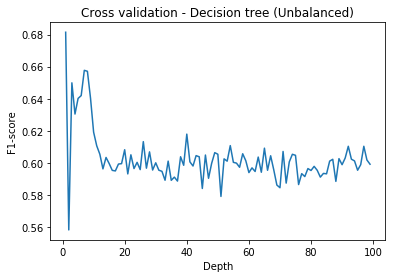

O melhor lambda é 1, com F1-score = 0.6814206373456876


In [31]:
cv_treeUnbalanced = pd.Series(cv_treeUnbalanced, index = depth_list)
cv_treeUnbalanced.plot(title = "Cross validation - Decision tree (Unbalanced)")
plt.xlabel("Depth")
plt.ylabel("F1-score")
plt.show()

print("O melhor lambda é {0}, com F1-score = {1}".format(cv_treeUnbalanced.idxmax(), cv_treeUnbalanced.max()))

### Dados balanceados

In [32]:
cv_treeBalanced = [cv_report(DecisionTreeClassifier(max_depth=depth), x_cc, y_cc, 5).mean()
            for depth in depth_list]

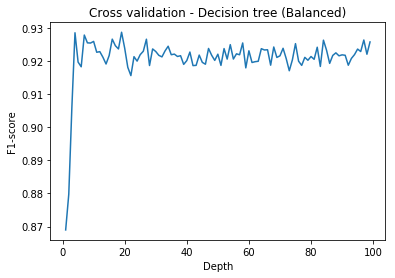

A melhor profundidade é 19, com F1-score = 0.9287894236954773


In [33]:
cv_treeBalanced = pd.Series(cv_treeBalanced, index = depth_list)
cv_treeBalanced.plot(title = "Cross validation - Decision tree (Balanced)")
plt.xlabel("Depth")
plt.ylabel("F1-score")
plt.show()

print("A melhor profundidade é {0}, com F1-score = {1}".format(cv_treeBalanced.idxmax(), cv_treeBalanced.max()))

In [34]:
decTree = DecisionTreeClassifier(max_depth=cv_treeBalanced.idxmax())
decTree.fit(x_cc,y_cc)

print("O F1 do modelo para todos os dados é {0}".format(real_f1(decTree)))

O F1 do modelo para todos os dados é 0.5538461538461539


## Adaboost

### Dados não balanceados

In [35]:
estimators = np.arange(1,50,1).tolist()

A quantidade de estimators ideal é 19, com F1 = 0.7191199579190005


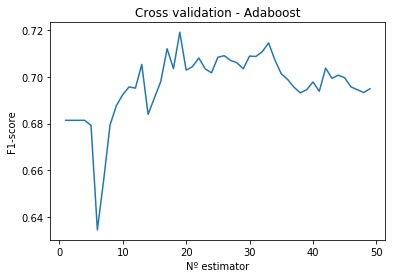

In [36]:
cv_adaBoostUnbalanced =  [cv_report(AdaBoostClassifier(algorithm="SAMME.R", n_estimators=estimator), treino_X, treino_Y, 5).mean()
            for estimator in estimators]

cv_adaBoostUnbalanced = pd.Series(cv_adaBoostUnbalanced, index = estimators)

cv_adaBoostUnbalanced.plot(title = "Cross validation - Adaboost")
plt.xlabel("Nº estimator")
plt.ylabel("F1-score")
print("A quantidade de estimators ideal é {0}, com F1 = {1}".format(cv_adaBoostUnbalanced.idxmax(), cv_adaBoostUnbalanced.max()))

### Dados balanceados

A quantidade de estimators ideal é 44, com F1 = 0.9529884200977516


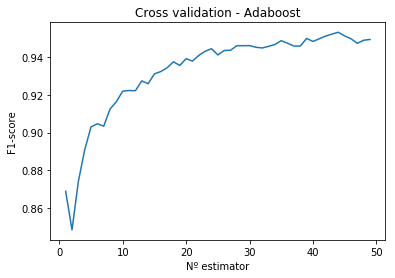

In [37]:
cv_adaBoostBalanced =  [cv_report(AdaBoostClassifier(algorithm="SAMME.R", n_estimators=estimator), x_cc, y_cc, 5).mean()
            for estimator in estimators]

cv_adaBoostBalanced = pd.Series(cv_adaBoostBalanced, index = estimators)


cv_adaBoostBalanced.plot(title = "Cross validation - Adaboost")
plt.xlabel("Nº estimator")
plt.ylabel("F1-score")
print("A quantidade de estimators ideal é {0}, com F1 = {1}".format(cv_adaBoostBalanced.idxmax(), cv_adaBoostBalanced.max()))

In [38]:
adaBoost = AdaBoostClassifier(algorithm="SAMME.R", n_estimators=cv_adaBoostBalanced.idxmax())
adaBoost.fit(x_cc,y_cc)

print("O F1 do modelo para todos os dados é {0}".format(real_f1(adaBoost)))

O F1 do modelo para todos os dados é 0.5962399283795882


Em todos os casos os modelos treinados com dados balanceados são melhores na validação com esses dados balanceados, porém quando testamos esses modelos com todos os dados, ele reduz bastante o valor da métrica F1, mostrando que os valores obtidos na validação desses modelos não se mostraram uma boa aproximação para o F1 real.

# 3) Reporte Precision, Recall e AUC-Precision&Recall no treino e validação. Há uma grande diferença de desempenho no treino/validação?

## Regressão logística

In [43]:
logRegBal = LogisticRegression(solver="lbfgs", max_iter=10000, C=cv_logRegBalanced.idxmax())

report = metric_report(logRegBal,x_cc,y_cc,5)
print("No treino: Precision = {0}, Recall = {1} e F1={2}".format(report[0][0],report[0][1],report[0][2]))
print("Na validação: Precision = {0}, Recall = {1} e F1={2}".format(report[1][0],report[1][1],report[1][2]))

No treino: Precision = 0.8495706913785831, Recall = 0.9302818440606601 e F1=0.8880939097877526
Na validação: Precision = 0.8424056956444022, Recall = 0.9202747486938001 e F1=0.8794663274504089


## KNN

In [44]:
knnBal = KNeighborsClassifier(n_neighbors=cv_knnBalanced.idxmax())

report = metric_report(knnBal,x_cc,y_cc,5)
print("No treino: Precision = {0}, Recall = {1} e F1={2}".format(report[0][0],report[0][1],report[0][2]))
print("Na validação: Precision = {0}, Recall = {1} e F1={2}".format(report[1][0],report[1][1],report[1][2]))

No treino: Precision = 0.8364801881714385, Recall = 0.9022745933025564 e F1=0.8681166073716968
Na validação: Precision = 0.8309922074167279, Recall = 0.8954607955623726 e F1=0.8619195883319317


## Decision Tree

In [45]:
treeBal = DecisionTreeClassifier(max_depth=cv_treeBalanced.idxmax())

report = metric_report(treeBal,x_cc,y_cc,5)
print("No treino: Precision = {0}, Recall = {1} e F1={2}".format(report[0][0],report[0][1],report[0][2]))
print("Na validação: Precision = {0}, Recall = {1} e F1={2}".format(report[1][0],report[1][1],report[1][2]))

No treino: Precision = 0.9980640225534984, Recall = 1.0 e F1=0.999029058233166
Na validação: Precision = 0.9259841148720115, Recall = 0.9147527764283522 e F1=0.9202026101275014


## Adaboost

In [46]:
adaboostBal = AdaBoostClassifier(algorithm="SAMME.R", n_estimators=cv_adaBoostBalanced.idxmax())

report = metric_report(adaboostBal,x_cc,y_cc,5)
print("No treino: Precision = {0}, Recall = {1} e F1={2}".format(report[0][0],report[0][1],report[0][2]))
print("Na validação: Precision = {0}, Recall = {1} e F1={2}".format(report[1][0],report[1][1],report[1][2]))

No treino: Precision = 0.9505006951366989, Recall = 0.9780848507924196 e F1=0.9640845324412727
Na validação: Precision = 0.9368983049640802, Recall = 0.9697011029222578 e F1=0.9529884200977516


Em todos os casos as métricas na validação são mais baixas do que as métricas no treino, isso se deve ao fato de que no treino o modelo se ajusta melhor, pois fará previsões dos dados que ele já conhece.

# 5) Envie seus melhores modelos à competição do Kaggle.

## Testando o modelo Random Forest

In [39]:
depth_list = np.arange(1,100,1).tolist()

cv_forest = [cv_report(RandomForestClassifier(max_depth = max_depth, n_estimators=100, random_state=7, class_weight="balanced_subsample"), treino_X, treino_Y, 5).mean()
            for max_depth in depth_list]

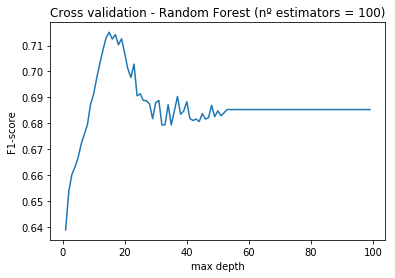

A melhor profundidade (para estimators=100) é 15, com F1 = 0.7151552906768677


In [48]:
cv_forest = pd.Series(cv_forest, index = depth_list)
cv_forest.plot(title = "Cross validation - Random Forest (nº estimators = 100)")
plt.xlabel("max depth")
plt.ylabel("F1-score")
plt.show()

print("A melhor profundidade (para estimators=100) é {0}, com F1 = {1}".format(cv_forest.idxmax(), cv_forest.max()))

In [49]:
estimators_list = np.arange(10,500,10).tolist()

cv_forest_dpMin = [cv_report(RandomForestClassifier(max_depth = cv_forest.idxmax(), n_estimators=n_estimators, random_state=7, class_weight="balanced_subsample"), treino_X, treino_Y, 5).mean()
            for n_estimators in estimators_list]

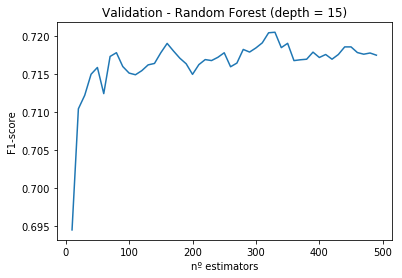

O melhor número de estimators (para profundidade=15) é 330, com F1 = 0.7205452337088387


In [50]:
cv_forest_dpMin = pd.Series(cv_forest_dpMin, index = estimators_list)
cv_forest_dpMin.plot(title = "Validation - Random Forest (depth = {0})".format(cv_forest.idxmax()))
plt.xlabel("nº estimators")
plt.ylabel("F1-score")
plt.show()

print("O melhor número de estimators (para profundidade={0}) é {1}, com F1 = {2}".format(cv_forest.idxmax(), cv_forest_dpMin.idxmax(), cv_forest_dpMin.max()))

In [51]:
rdForest = RandomForestClassifier(max_depth=cv_forest.idxmax(), n_estimators=cv_forest_dpMin.idxmax(), random_state=7)
rdForest.fit(x_cc,y_cc)

print("O F1 do modelo para todos os dados é {0}".format(real_f1(rdForest)))

O F1 do modelo para todos os dados é 0.6587479935794542


## Dados para envio

In [47]:
lgModel = LogisticRegression(solver="lbfgs", max_iter=10000, C=1.69, random_state=1)
lgModel.fit(x_cc,y_cc)

predictions = lgModel.predict(teste)

O modelo com o melhor F1 foi a regressão logística.

In [53]:
envio = pd.read_csv("sample_submission.csv")

envio["Predicted"] = predictions
envio["Predicted"] = envio["Predicted"].replace([0, 1],['nao_eleito', 'eleito'])

In [55]:
envio.to_csv("Envio.csv", index=False)